In [58]:
import pandas as pd
from torch import nn
import torch
train_data = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")
sample = pd.read_csv("../data/sample_submission.csv")
big_data = pd.read_csv("../data/apassXgalex.csv")
whole_data = pd.read_csv("../data/whole_data_practice3.csv")
device = "cuda" if torch.cuda.is_available() else "cpu"

big_data = big_data.dropna()
whole_data = whole_data.iloc[:, :-3]
whole_data["present"].value_counts()[1]
whole_data

,RAJ2000,DEJ2000,nobs,Vmag,e_Vmag,Bmag,e_Bmag,gpmag,e_gpmag,rpmag,e_rpmag,ipmag,e_ipmag,fuv_mag,nuv_mag,err,present
0,129.872235,18.219273,6,10.388,0.033,11.080,0.024,13.351,3.579,12.599,3.330,10.066,0.031,22.017,15.786,4.888841,0
1,143.755605,4.997145,5,14.104,0.053,14.767,0.040,14.272,0.209,15.754,4.109,13.373,0.773,23.920,19.509,4.186825,0
2,141.550218,2.826565,5,12.346,0.046,12.909,0.045,12.494,0.197,14.430,3.722,11.920,0.520,23.090,16.583,3.763859,0
3,143.899031,4.676475,4,13.661,0.041,14.127,0.041,13.766,0.181,15.375,3.672,13.049,0.672,24.091,17.881,3.737819,0
4,141.728736,2.834912,4,13.468,0.077,14.042,0.048,13.634,0.208,15.422,3.632,13.227,0.000,22.714,17.651,3.639082,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64983,121.733932,34.774408,5,8.090,0.000,9.274,0.000,8.712,0.000,7.674,0.000,7.320,0.000,23.701,16.685,0.000000,0
64984,164.209694,5.631360,6,9.012,0.000,9.501,0.000,9.185,0.000,8.873,0.000,8.775,0.000,20.023,13.518,0.000000,0
64985,197.822409,-3.915387,3,8.558,0.000,9.722,0.000,9.115,0.000,8.152,0.000,7.835,0.000,22.929,16.748,0.000000,0
64986,216.499182,6.938758,4,9.354,0.000,9.858,0.000,9.633,0.000,9.306,0.000,9.203,0.000,18.501,13.158,0.000000,0


In [59]:
coords = big_data.iloc[:, 1:3].to_csv("../data/coords.csv", index=False, header=False)
coords
variable_cnt = whole_data["present"].value_counts()[1]
non_variable = whole_data[whole_data["present"] == 0]
non_variable = non_variable.sample(variable_cnt)
non_variable = non_variable
non_variable
variable = whole_data[whole_data["present"] == 1]
pd.concat([non_variable, variable], ignore_index=True)
rest_data = whole_data.drop((non_variable.index).append(variable.index))

In [60]:
from sklearn.preprocessing import StandardScaler
train = whole_data.iloc[:, :-1]
labels = whole_data["present"]

# train = whole_data.iloc[:, :-1]
# train = pd.concat([non_variable, variable], ignore_index=True)
# labels = train["present"]
# train = train.iloc[:, :-1]
# # Initialize the scaler
# scaler = StandardScaler()

# # Fit and transform the data
# train = pd.DataFrame(scaler.fit_transform(train), columns=train.columns)

print(train.shape, labels.shape)

X = torch.from_numpy(train.values).type(torch.float)
Y = torch.from_numpy(labels.values).type(torch.float)

T = torch.from_numpy(test.iloc[:, 1:6].values).type(torch.float)
T_test = torch.from_numpy(sample["0"].values).type(torch.float)
print(train.shape[1])

(64988, 16) (64988,)
16


In [61]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_test = X_train.to(device), X_test.to(device)
Y_train, Y_test = Y_train.to(device), Y_test.to(device)
# X_train, X_test = X, T
# Y_train, Y_test = Y, T_test
# X_test, X_train = X, T
# Y_test, Y_train = Y, T_test # это веселья ради

In [62]:
from imblearn.over_sampling import SMOTE

def apply_smote():
  # Apply SMOTE
  smote = SMOTE(random_state=42)
  X_train_resampled, Y_train_resampled = smote.fit_resample(X_train.cpu().numpy(), Y_train.cpu().numpy())

  # Convert back to PyTorch tensors
  X_train_resampled = torch.tensor(X_train_resampled, dtype=torch.float32).to(device)
  Y_train_resampled = torch.tensor(Y_train_resampled, dtype=torch.float32).to(device)
  X_train, Y_train = X_train_resampled, Y_train_resampled


In [63]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()  # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

def recall_fn(y_true, y_pred):
    tp = torch.sum(torch.logical_and(y_true == 1, y_pred == 1)).item()
    recall = (tp / torch.sum(y_true == 1).item()) * 100
    return recall

def precision_fn(y_true, y_pred):
    tp = torch.sum((y_true == 1) & (y_pred == 1)).item()
    fp = torch.sum((y_true == 0) & (y_pred == 1)).item()
    precision = (tp / (tp + fp)) * 100 if (tp + fp) > 0 else 0.0
    return precision

def f1_score_fn(y_true, y_pred):
    recall = recall_fn(y_true, y_pred)
    precision = precision_fn(y_true, y_pred)
    if precision + recall > 0:
        f1 = 2 * (precision * recall) / (precision + recall)
    else:
        f1 = 0.0
    return f1


In [64]:
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingWarmRestarts, CyclicLR
from torch.utils.tensorboard import SummaryWriter

in_features_n = train.shape[1]
features_n = 256
features_n_2 = 64

class Model(nn.Module):
    def __init__(self, hidden_units=features_n_2, dropout_rate=0.5):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=in_features_n, out_features=features_n)
        self.layer_2 = nn.Linear(in_features=features_n, out_features=hidden_units)
        self.layer_3 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
        self.layer_4 = nn.Linear(in_features=hidden_units, out_features=1)
        self.bn1 = nn.BatchNorm1d(features_n)  # Batch normalization
        self.act1 = nn.LeakyReLU(negative_slope=0.01)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.bn2 = nn.BatchNorm1d(hidden_units)
        self.act2 = nn.GELU()
        self.act3 = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.act1(self.layer_1(x))
        x = self.dropout(x)
        x = self.act1(self.layer_2(x))
        x = self.dropout(x)
        x = self.act1(self.layer_3(x))
        x = self.dropout(x)
        x = self.sigmoid(self.layer_4(x))
        return x

import optuna

def objective(trial):
    # Define hyperparameters to tune
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    hidden_units = trial.suggest_int('hidden_units', 64, 256)

    # Define model with tuned hyperparameters
    model = Model(hidden_units, dropout_rate).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    # Training loop
    for epoch in range(10000):
        model.train()
        y_logits = model(X_train).squeeze()
        loss = loss_fn(y_logits, Y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate on validation set
    model.eval()
    with torch.inference_mode():
        test_logits = model(X_test).squeeze()
        test_loss = loss_fn(test_logits, Y_test)
    
    return test_loss

if (1==0):
    # Run Optuna study
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)

    # Best hyperparameters
    print(study.best_params)


In [65]:
model = Model(hidden_units=64, dropout_rate=0.357).to(device)
# Calculate class weights
num_zeros = torch.sum(Y_train == 0).item()
num_ones = torch.sum(Y_train == 1).item()
weight_for_1 =  num_zeros / num_ones * 1.33 # Higher weight for class 1
# weight_for_1 =  1 # Higher weight for class 1
print(weight_for_1)
pos_weight = torch.tensor([weight_for_1]).to(device)

# Define loss function with pos_weight
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# loss_fn = nn.BCELoss()

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001, weight_decay=1e-4)

# scheduler = StepLR(optimizer, step_size=20000, gamma=0.1)
# scheduler = CyclicLR(optimizer, base_lr=0.00001, max_lr=0.001, step_size_up=2000, mode='triangular')
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=50, T_mult=2, eta_min=1e-5)

torch.manual_seed(42)

epochs = 5000


best_test_loss = float('inf')
patience = 20000
no_improvement = 0

for epoch in range(epochs):
    model.train()

    # Forward pass
    y_logits = model(X_train).squeeze()
    y_pred = torch.round(y_logits)  # Binary predictions (0 or 1)
    
    # Calculate loss and accuracy
    loss = loss_fn(y_logits, Y_train)  # Pass probabilities to loss function
    acc = accuracy_fn(y_true=Y_train, y_pred=y_pred)
    train_recall = recall_fn(y_true=Y_train, y_pred=y_pred)
    train_f1 = f1_score_fn(y_true=Y_train, y_pred=y_pred)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    # # Evaluation
    model.eval()
    with torch.inference_mode():
        # Forward pass
        test_logits = model(X_test).squeeze()
        test_pred = torch.round(test_logits)  # Binary predictions (0 or 1)
        # Calculate test loss, accuracy, and recall
        test_loss = loss_fn(test_logits, Y_test)  # Pass probabilities to loss function
        test_acc = accuracy_fn(y_true=Y_test, y_pred=test_pred)
        test_recall = recall_fn(y_true=Y_test, y_pred=test_pred)
        test_f1 = f1_score_fn(y_true=Y_test, y_pred=test_pred)
    
    # Early stopping
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        no_improvement = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        no_improvement += 1
    
    if no_improvement >= patience:
        print(f"Early stopping at epoch {epoch}")
        break
    

    # Print metrics
    if epoch % 1000 == 0:

        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}%, Recall: {train_recall:.2f}, " +
              f"F1 score: {train_f1:.2f} | Test acc: {test_acc:.2f}%, Test F1 score: {test_f1:.2f}, " +
              f"Test recall: {test_recall:.2f}")


11.82076074553062
Epoch: 0 | Loss: 1.45402, Accuracy: 75.60%, Recall: 17.36, F1 score: 12.58 | Test acc: 89.80%, Test F1 score: 0.00, Test recall: 0.00
Epoch: 1000 | Loss: 1.27291, Accuracy: 77.65%, Recall: 64.64, F1 score: 36.91 | Test acc: 78.43%, Test F1 score: 38.24, Test recall: 65.46
Epoch: 2000 | Loss: 1.26181, Accuracy: 76.93%, Recall: 68.33, F1 score: 37.47 | Test acc: 79.23%, Test F1 score: 39.62, Test recall: 66.82
Epoch: 3000 | Loss: 1.25234, Accuracy: 79.47%, Recall: 67.48, F1 score: 39.93 | Test acc: 79.18%, Test F1 score: 39.49, Test recall: 66.59
Epoch: 4000 | Loss: 1.25243, Accuracy: 78.80%, Recall: 68.03, F1 score: 39.36 | Test acc: 79.13%, Test F1 score: 39.46, Test recall: 66.67


In [66]:
import numpy as np

def accuracy_fn_np(y_true, y_pred):
    correct = np.sum(y_true == y_pred)  # np.sum() calculates the number of equal elements
    acc = (correct / len(y_pred)) * 100
    return acc

def recall_fn_np(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))  # True positives
    recall = (tp / np.sum(y_true == 1)) * 100
    return recall

(12998,)
(12998,)
78.75057701184798
(64818,)
(64818,)
79.90064488259434


Text(0.5, 1.0, 'Confusion Matrix on whole data')

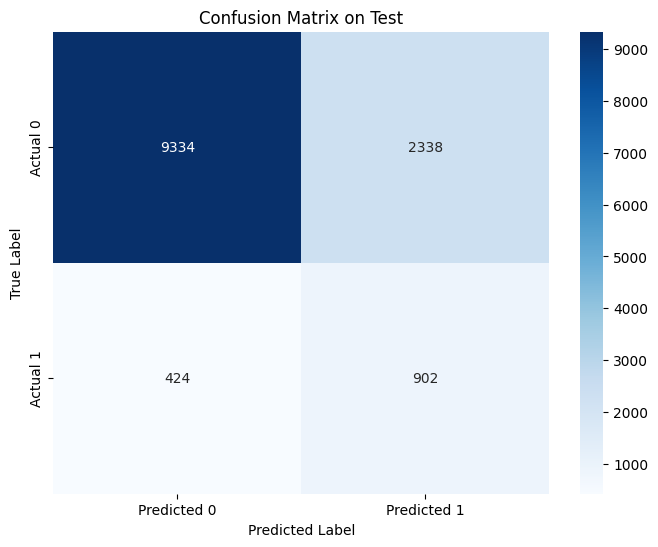

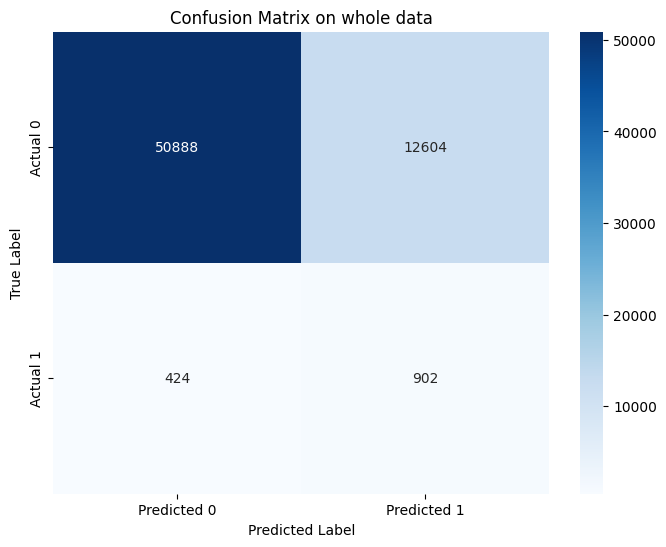

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
test_pred = X_test.cpu().numpy()
# test_pred = whole_data.iloc[:, :-1].to_numpy()
test_pred = torch.from_numpy(test_pred).type(torch.float).to(device)
test_pred = torch.round(model(test_pred)).squeeze()

true = Y_test.cpu().numpy()
# true = whole_data["present"]

test_pred = test_pred.cpu()
test_pred = test_pred.detach()
test_pred = test_pred.numpy()
test_true = true

print(test_true.shape)
print(test_pred.shape)
print(accuracy_fn_np(test_true, test_pred))

# Compute the confusion matrix
cm = confusion_matrix(test_true, test_pred)

# Plot the confusion matrix using Seaborn's heatmap
plt.style.use("default")
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Test')
# plt.show()
# test_pred
# test_pred = X_test.cpu().numpy()
test_pred = rest_data.iloc[:, :-1].to_numpy()
test = X_test.cpu().numpy()
test_pred = np.concat([test_pred, test]) 
test_pred = torch.from_numpy(test_pred).type(torch.float).to(device)
test_pred = torch.round(model(test_pred)).squeeze()

# true = Y_test.cpu().numpy()
true = rest_data["present"]
true = np.concat([true, Y_test.cpu().numpy()])

test_pred = test_pred.cpu()
test_pred = test_pred.detach()
test_pred = test_pred.numpy()
test_true = true

print(test_true.shape)
print(test_pred.shape)
print(accuracy_fn_np(test_true, test_pred))

# Compute the confusion matrix
cm = confusion_matrix(test_true, test_pred)

# Plot the confusion matrix using Seaborn's heatmap
plt.style.use("default")
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on whole data')

(51990,)
(51990,)
79.41719561454126


Text(0.5, 1.0, 'Confusion Matrix')

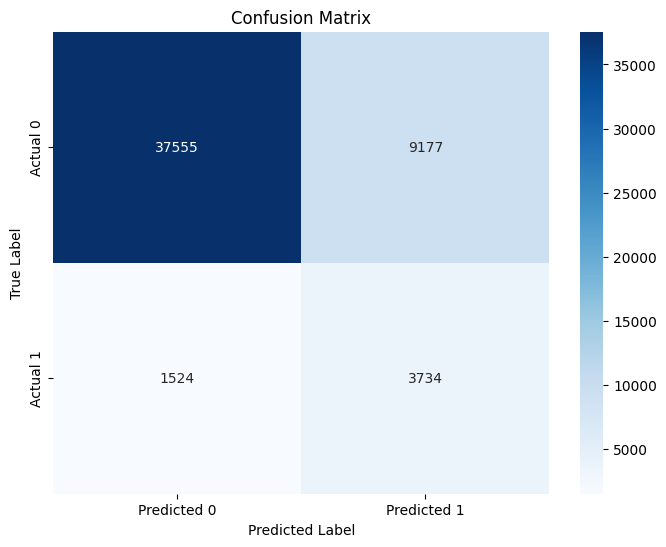

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
test_pred = X_train.cpu().numpy()
# test_pred = whole_data.iloc[:, :-1].to_numpy()
test_pred = torch.from_numpy(test_pred).type(torch.float).to(device)
test_pred = torch.round(model(test_pred)).squeeze()

true = Y_train.cpu().numpy()
# true = whole_data["present"]

test_pred = test_pred.cpu()
test_pred = test_pred.detach()
test_pred = test_pred.numpy()
test_true = true

print(test_true.shape)
print(test_pred.shape)
print(accuracy_fn_np(test_true, test_pred))

# Compute the confusion matrix
cm = confusion_matrix(test_true, test_pred)

# Plot the confusion matrix using Seaborn's heatmap
plt.style.use("default")
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
# plt.show()
# test_pred